<ipython-input-9-7e5e3eb77607>:112: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='beds',
<ipython-input-9-7e5e3eb77607>:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(x='location',
<ipython-input-9-7e5e3eb77607>:142: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax4.set_xticklabels(ax4.get_xticklabels(),



Location Analysis:

Number of properties by location:
location
                 36
South            27
Jamaica Plain    24
South End        21
West Roxbury     19
Back Bay         16
Dorchester       16
Brighton         13
Roslindale       12
Charlestown      11
Name: count, dtype: int64

Median price by location:
location
Eight Streets Neighborhood        $4,150,000.00
Bay Village                       $3,495,000.00
Farlow Hill                       $3,388,000.00
Midtown                           $2,675,000.00
Seaport District                  $2,397,500.00
Chinatown                         $2,088,000.00
Waterfront                        $2,024,999.00
Back Bay                          $1,949,500.00
Charlestown Gas Light District    $1,800,000.00
Newton                            $1,695,000.00
Name: price, dtype: object

Average square footage by location:
location
Farlow Hill                   6,039 sq ft
Dorchester Fields Corner      3,300 sq ft
Chinatown                     2,988 s

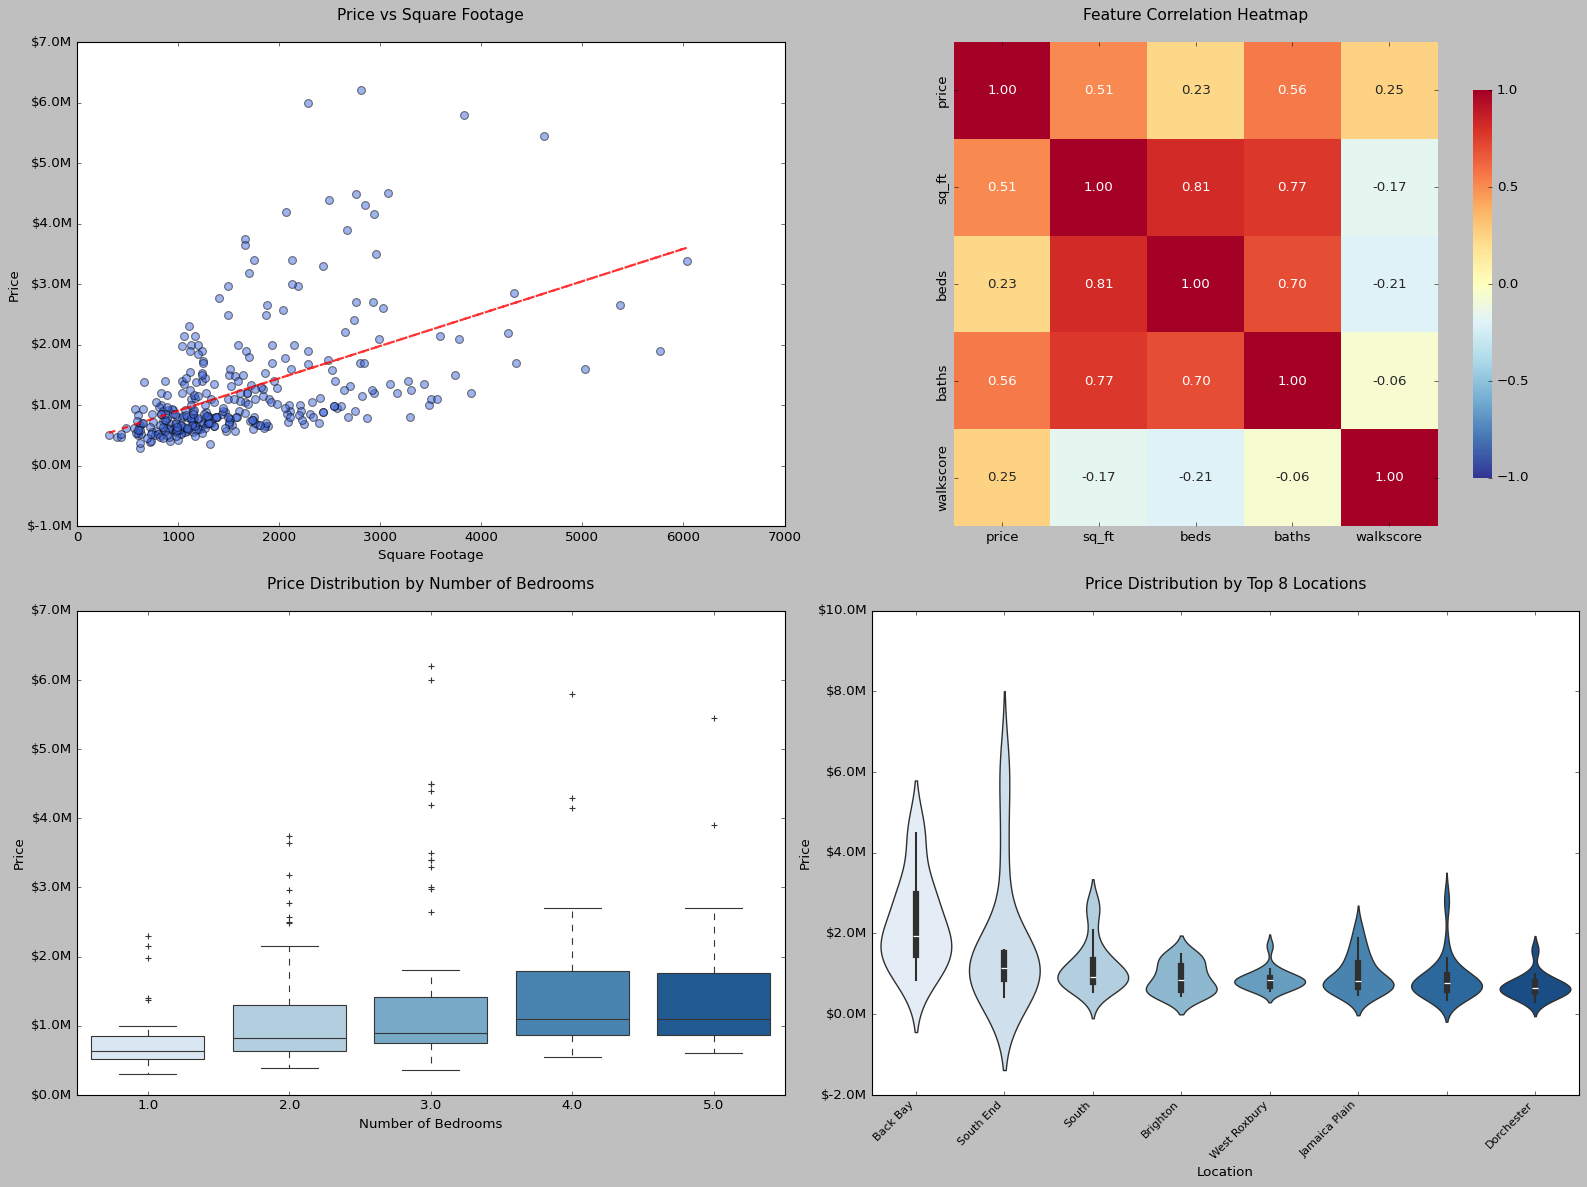

In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

def extract_location_improved(row):
    """
    Extract location from key_details field using the 'New construction:' tag
    If not found, try to extract from other fields
    """
    try:
        # First try to get location from key_details
        if pd.notna(row['key_details']):
            details = str(row['key_details'])
            if 'New construction:' in details:
                location = details.split('New construction:')[-1].strip()
                return clean_location(location)

        # If no location found in key_details, try description
        if pd.notna(row['description']):
            desc = str(row['description']).lower()
            # List of known Boston neighborhoods and areas
            neighborhoods = [
                'Back Bay', 'Beacon Hill', 'North End', 'South End', 'Fenway',
                'South Boston', 'East Boston', 'Charlestown', 'Dorchester',
                'Jamaica Plain', 'Roxbury', 'West Roxbury', 'Brighton', 'Allston',
                'Hyde Park', 'Roslindale', 'Seaport', 'Waterfront', 'Bay Village',
                'Leather District', 'Chinatown', 'Fort Point', 'Mission Hill'
            ]

            # Search for neighborhoods in description
            for hood in neighborhoods:
                if hood.lower() in desc:
                    return hood

        return "Other"
    except:
        return "Other"

def clean_location(location):
    """Clean and standardize location names"""
    # Remove common suffixes and standardize names
    location = str(location).strip()
    replacements = {
        "'s": "",
        "Boston's": "",
        ", Boston": "",
        ", MA": "",
        "Boston": ""
    }

    for old, new in replacements.items():
        location = location.replace(old, new)

    # Map common variations to standard names
    location_mapping = {
        "Southie": "South Boston",
        "JP": "Jamaica Plain",
        "South Boston Waterfront": "Seaport",
        "Financial District": "Downtown",
        "Downtown Boston": "Downtown",
        "South Boston's City Point": "South Boston",
        "East Boston's Jeffries Point": "East Boston",
        "Dorchester's Savin Hill": "Dorchester"
    }

    return location_mapping.get(location.strip(), location.strip())

def millions_formatter(x, pos):
    """Format numbers in millions for price axis"""
    return f'${x/1e6:.1f}M'

def create_visualizations(df):
    plt.style.use('classic')
    fig = plt.figure(figsize=(20, 15))

    # 1. Scatter plot: Square Footage vs Price
    ax1 = plt.subplot(2, 2, 1)
    scatter = ax1.scatter(df['sq_ft'], df['price'], alpha=0.5, c='royalblue', s=50)
    ax1.set_xlabel('Square Footage', fontsize=12)
    ax1.set_ylabel('Price', fontsize=12)
    ax1.set_title('Price vs Square Footage', fontsize=14, pad=20)

    # Add trend line
    z = np.polyfit(df['sq_ft'], df['price'], 1)
    p = np.poly1d(z)
    ax1.plot(df['sq_ft'], p(df['sq_ft']), "r--", alpha=0.8, linewidth=2)
    ax1.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

    # 2. Correlation Heatmap
    ax2 = plt.subplot(2, 2, 2)
    numeric_cols = ['price', 'sq_ft', 'beds', 'baths', 'walkscore']
    correlation_matrix = df[numeric_cols].corr()

    sns.heatmap(correlation_matrix,
                annot=True,
                cmap='RdYlBu_r',
                vmin=-1,
                vmax=1,
                center=0,
                fmt='.2f',
                square=True,
                cbar_kws={"shrink": .8},
                ax=ax2)

    ax2.set_title('Feature Correlation Heatmap', fontsize=14, pad=20)

    # 3. Price Distribution by Bedrooms
    ax3 = plt.subplot(2, 2, 3)
    valid_beds = df[df['beds'].between(0, 5)]
    sns.boxplot(x='beds',
                y='price',
                data=valid_beds,
                palette='Blues',
                ax=ax3)

    ax3.set_xlabel('Number of Bedrooms', fontsize=12)
    ax3.set_ylabel('Price', fontsize=12)
    ax3.set_title('Price Distribution by Number of Bedrooms', fontsize=14, pad=20)
    ax3.yaxis.set_major_formatter(FuncFormatter(millions_formatter))

    # 4. Price Distribution by Location (Top 8 locations)
    ax4 = plt.subplot(2, 2, 4)

    # Get top locations excluding 'Other'
    location_counts = df[df['location'] != 'Other']['location'].value_counts()
    top_locations = location_counts.nlargest(8).index
    location_data = df[df['location'].isin(top_locations)]

    # Calculate median prices for sorting
    median_prices = location_data.groupby('location')['price'].median().sort_values(ascending=False)
    location_order = median_prices.index

    sns.violinplot(x='location',
                   y='price',
                   data=location_data,
                   order=location_order,
                   palette='Blues',
                   ax=ax4)

    ax4.set_xticklabels(ax4.get_xticklabels(),
                        rotation=45,
                        ha='right',
                        fontsize=10)

    ax4.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    ax4.set_xlabel('Location', fontsize=12)
    ax4.set_ylabel('Price', fontsize=12)
    ax4.set_title('Price Distribution by Top 8 Locations', fontsize=14, pad=20)

    plt.tight_layout()
    return fig

def analyze_location_stats(df):
    """Print detailed location statistics"""
    print("\nLocation Analysis:")
    print("\nNumber of properties by location:")
    location_counts = df['location'].value_counts()
    print(location_counts.head(10))

    print("\nMedian price by location:")
    median_prices = df.groupby('location')['price'].median().sort_values(ascending=False)
    print(median_prices.head(10).apply(lambda x: f"${x:,.2f}"))

    print("\nAverage square footage by location:")
    avg_sqft = df.groupby('location')['sq_ft'].mean().sort_values(ascending=False)
    print(avg_sqft.head(10).apply(lambda x: f"{x:,.0f} sq ft"))

def visualize_housing_data(df):
    # Clean and prepare data
    df['price'] = pd.to_numeric(df['price'], errors='coerce')
    df['sq_ft'] = pd.to_numeric(df['sq_ft'], errors='coerce')
    df['beds'] = pd.to_numeric(df['beds'], errors='coerce')
    df['baths'] = pd.to_numeric(df['baths'], errors='coerce')

    # Extract location with improved method
    df['location'] = df.apply(extract_location_improved, axis=1)

    # Extract walkscore
    df['walkscore'] = df['walkscore'].str.extract(r'Walk: (\d+)').astype(float)

    # Drop rows with missing values in key fields
    df = df.dropna(subset=['price', 'sq_ft', 'beds', 'baths', 'walkscore'])

    # Filter out extreme outliers
    df = df[df['price'] < df['price'].quantile(0.99)]
    df = df[df['sq_ft'] < df['sq_ft'].quantile(0.99)]

    # Create visualizations
    viz = create_visualizations(df)

    # Print detailed statistics
    analyze_location_stats(df)

    return viz

if __name__ == "__main__":
    df = pd.read_csv('/content/processed_listings.csv')

    viz = visualize_housing_data(df)
    plt.show()